In [224]:
# use pyproject group: experiments_analysis
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import yaml


In [225]:
# Load YAML file
with open('../../results.yaml') as file:
    data = yaml.safe_load(file)

# Process metrics per experiment call
rows = []
for experiment in data['experiments']:
    if not experiment['results']:
        continue
    for result in experiment['results']:
        if "metrics" not in result: continue
        metrics = result['metrics']
        kwargs = result['kwargs']
        options = {
            'samplepoints': kwargs.get('samplepoints', 0),
            **{
                f"option_{k}":v
                for k,v in kwargs.get('config', {}).items()
            }
        }
        options.update
        # Annotate metrics with experiment name and date
        row = {
            'experiment': experiment['name'],
            'date': data['date'],
            **metrics,
            **options
            }
        rows.append(row)

# Convert to DataFrame
df = pd.DataFrame(rows)
df['share_of_weights_loading'] = df['us_per_weights_loading'] / df['us_per_all']
print(df.keys())


KeyError: 'metrics'

In [ ]:
correlation_matrix = df[['uJ_per_all', 'uJ_per_inference',
       'uJ_per_input_loading', 'uJ_per_weights_loading', 'uW_per_all',
       'uW_per_inference', 'uW_per_input_loading', 'uW_per_weights_loading',
       'us_per_all', 'us_per_inference', 'us_per_input_loading',
       'us_per_weights_loading', 'option_GCR.pclkdiv.cnnclkdiv']].corr()
print(correlation_matrix)
# Get the highest correlation and anticorrelation
# Exclude self-correlations by masking the diagonal
correlation_pairs = correlation_matrix.where(~np.eye(correlation_matrix.shape[0], dtype=bool)).stack()

highest_corr = correlation_pairs.nlargest(5).reset_index().values.tolist()
highest_anticorr = correlation_pairs.nsmallest(5).reset_index().values.tolist()

print("Highest Correlations:", highest_corr)
print("Highest Anticorrelations:", highest_anticorr)

                              uJ_per_all  uJ_per_inference  \
uJ_per_all                      1.000000          0.182575   
uJ_per_inference                0.182575          1.000000   
uJ_per_input_loading                 NaN               NaN   
uJ_per_weights_loading               NaN               NaN   
uW_per_all                      0.925388          0.318074   
uW_per_inference                0.815701          0.600581   
uW_per_input_loading                 NaN               NaN   
uW_per_weights_loading         -0.098837          0.098767   
us_per_all                      0.165590         -0.224814   
us_per_inference                     NaN               NaN   
us_per_input_loading            0.163734         -0.223608   
us_per_weights_loading          0.167156         -0.225607   
option_GCR.pclkdiv.cnnclkdiv    0.055147          0.036486   

                              uJ_per_input_loading  uJ_per_weights_loading  \
uJ_per_all                                     NaN   

/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


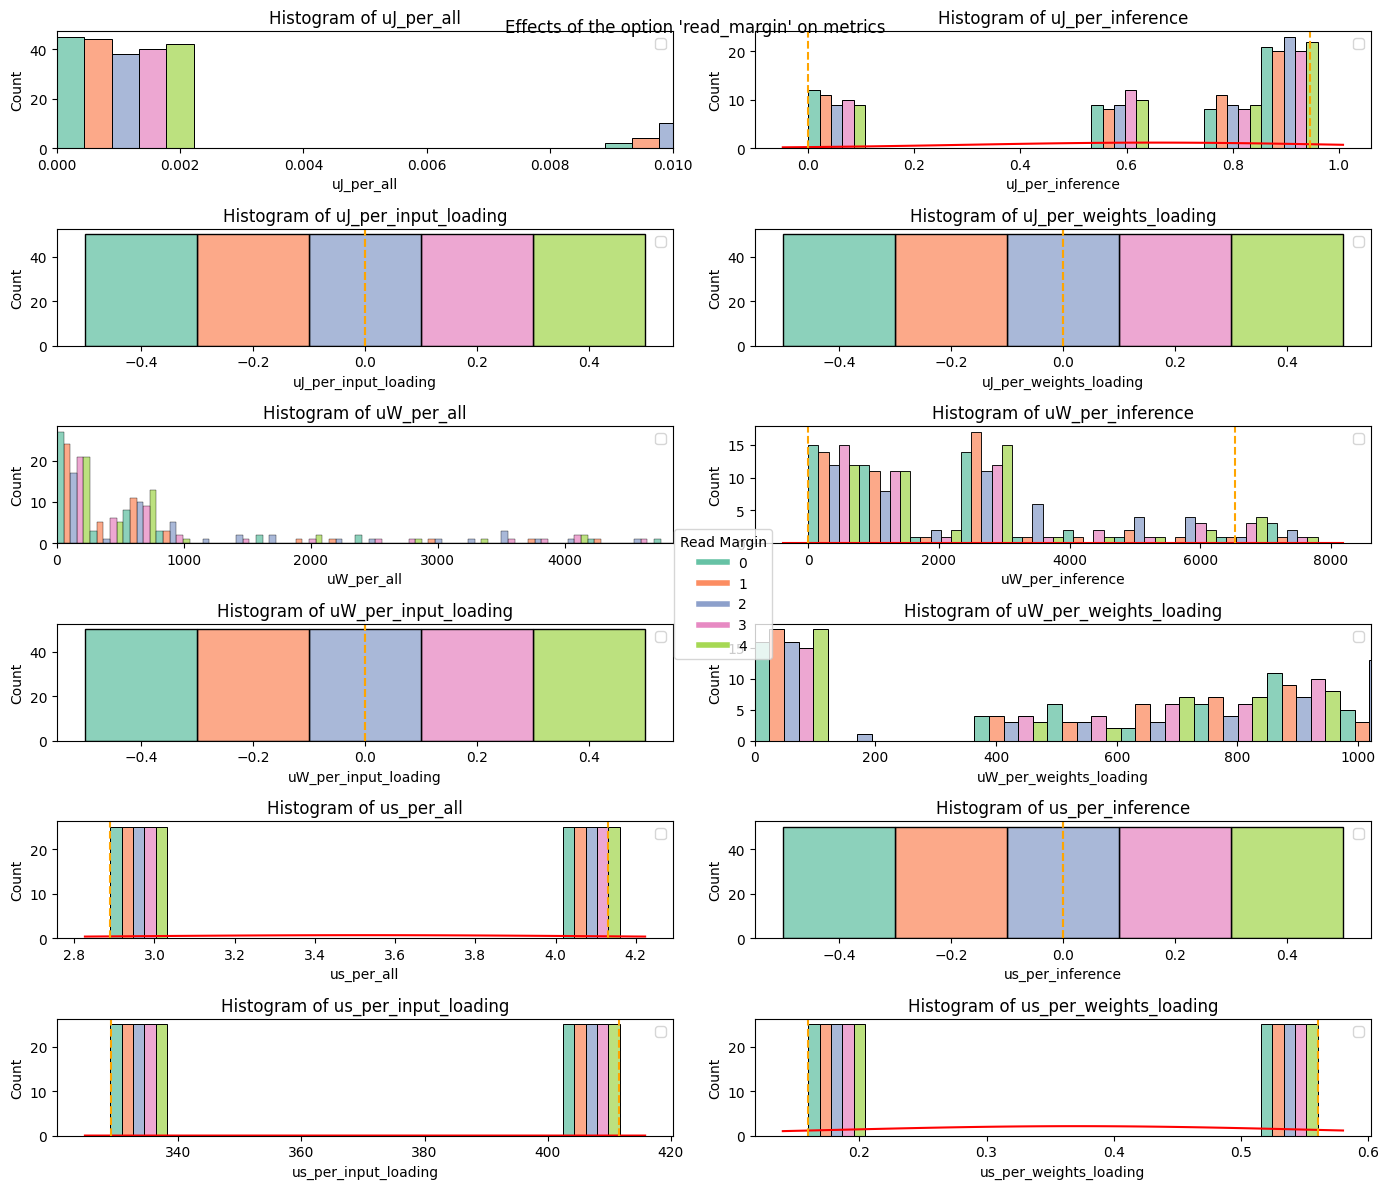

In [ ]:
quantil = 0.95
option = 'option_GCR.pclkdiv.cnnclkdiv'
# List of metrics to plot (replace with your actual metric column names)
metrics = ['uJ_per_all', 'uJ_per_inference',
       'uJ_per_input_loading', 'uJ_per_weights_loading', 'uW_per_all',
       'uW_per_inference', 'uW_per_input_loading', 'uW_per_weights_loading',
       'us_per_all', 'us_per_inference', 'us_per_input_loading',
       'us_per_weights_loading'
       ]

# Filter for 95th percentile for each metric
df_filtered = df.copy()
for metric in metrics:
    # quantile = df[metric].quantile(quantil)
    # df_filtered = df_filtered[df_filtered[metric] <= quantile]
    ...

# Set up the subplots
fig, axes = plt.subplots(math.ceil(len(metrics)/2), 2, figsize=(14, 12))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each metric
for i, metric in enumerate(metrics):
    sns.histplot(
        data=df_filtered,
        x=metric,
        hue=option,
        multiple='dodge', # ['layer', 'stack', 'fill', 'dodge']
        ax=axes[i],
        palette='Set2'
        )
    axes[i].set_title(f'Histogram of {metric}')
    quantile_minus = df[metric].quantile(1-quantil)
    quantile_plus = df[metric].quantile(quantil)

    if i not in [0, 4, 7]:
        # Overlay the PDF
        mean = df_filtered[metric].mean()
        std = df_filtered[metric].std()
        xmin, xmax = axes[i].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        pdf = stats.norm.pdf(x, mean, std)
        axes[i].plot(x, pdf, color='red', label='PDF')

        # Add the quantile bars
        axes[i].axvline(quantile_plus, color='orange', linestyle='--', label='95th Percentile +')
        axes[i].axvline(quantile_minus, color='orange', linestyle='--', label='95th Percentile -')
    else:
        # zoom to the quantile
        axes[i].set_xlim([quantile_minus, quantile_plus])
    axes[i].legend([])


plt.tight_layout()

# Create a global legend
unique_experiments = df_filtered[option].unique()
handles = [plt.Line2D([0], [0], color=sns.color_palette('Set2')[i], lw=4) for i in range(len(unique_experiments))]
fig.legend(
    handles,
    unique_experiments,
    loc='center',
    title='Read Margin',
    bbox_to_anchor=(0.52, 0.5)
    )  # Adjust location as needed
plt.suptitle("Effects of the option 'read_margin' on metrics")
plt.show()


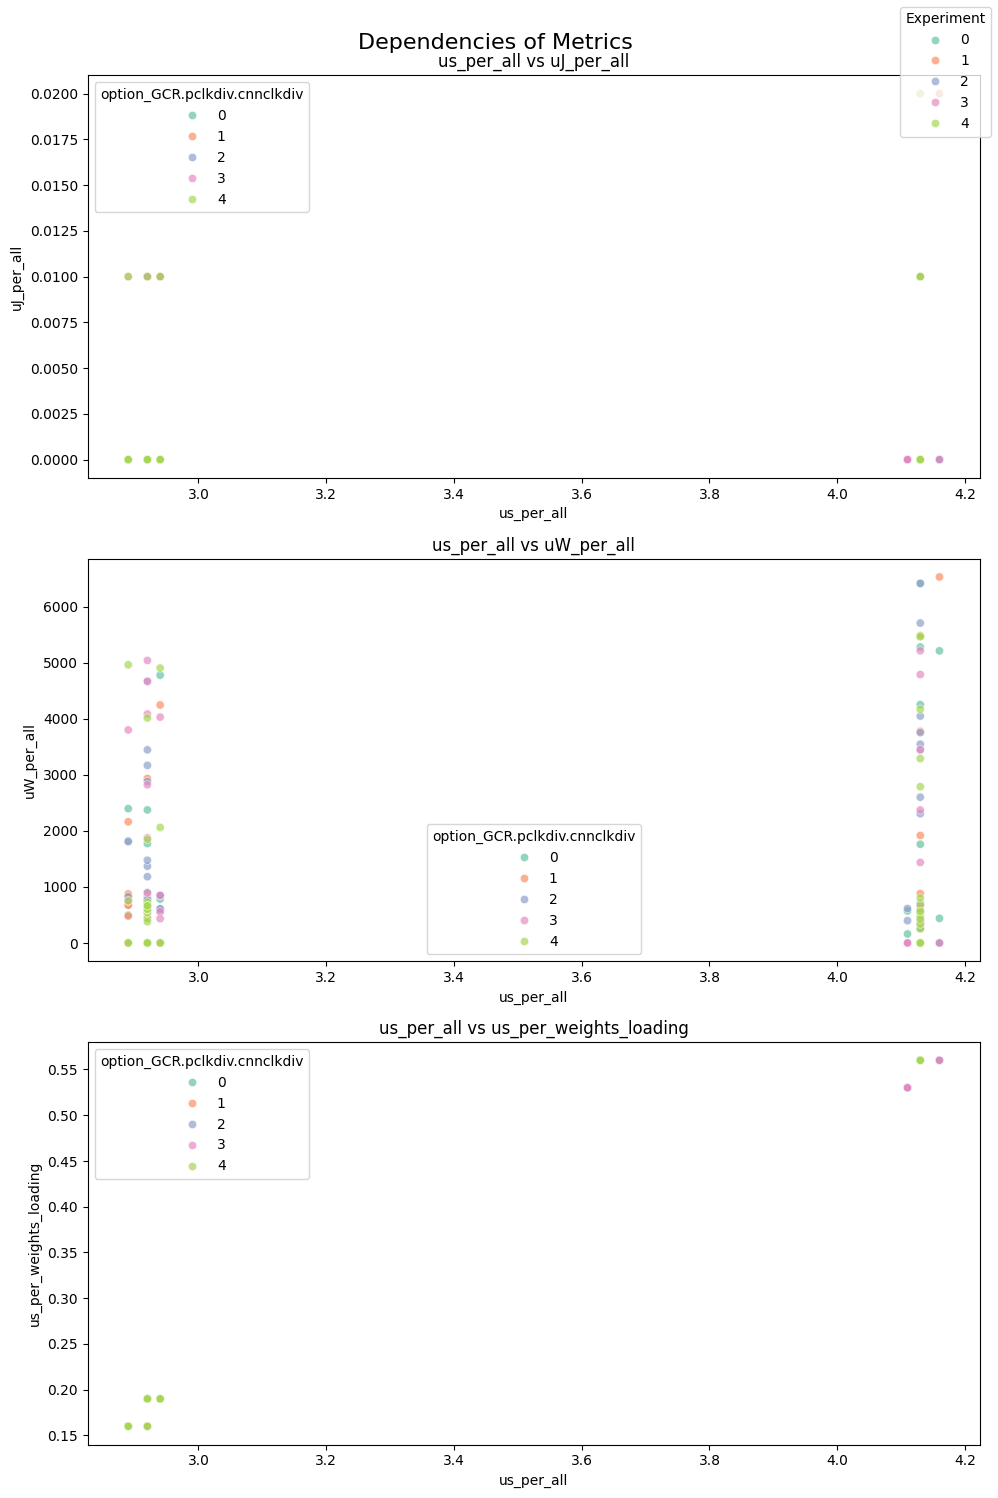

In [ ]:
# Define the list of metric pairs for plotting
metric_pairs = [
    ('us_per_all', 'uJ_per_all'),
    ('us_per_all', 'uW_per_all'),
    ('us_per_all', 'us_per_weights_loading'),
]

# Set up subplots based on the number of pairs
fig, axes = plt.subplots(len(metric_pairs), 1, figsize=(10, 5 * len(metric_pairs)))  # Adjust as needed

# Plot each pair
for i, (x_metric, y_metric) in enumerate(metric_pairs):
    sns.scatterplot(data=df_filtered, x=x_metric, y=y_metric, hue=option, ax=axes[i], palette='Set2', alpha=0.7)
    # Set title for each subplot
    axes[i].set_title(f'{x_metric} vs {y_metric}')

# Create a global legend using handles and labels from the first axis
handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first axis
fig.legend(handles, labels, loc='upper right', title='Experiment')

# Set the overall title for the figure
fig.suptitle('Dependencies of Metrics', fontsize=16)

plt.tight_layout()
plt.show()

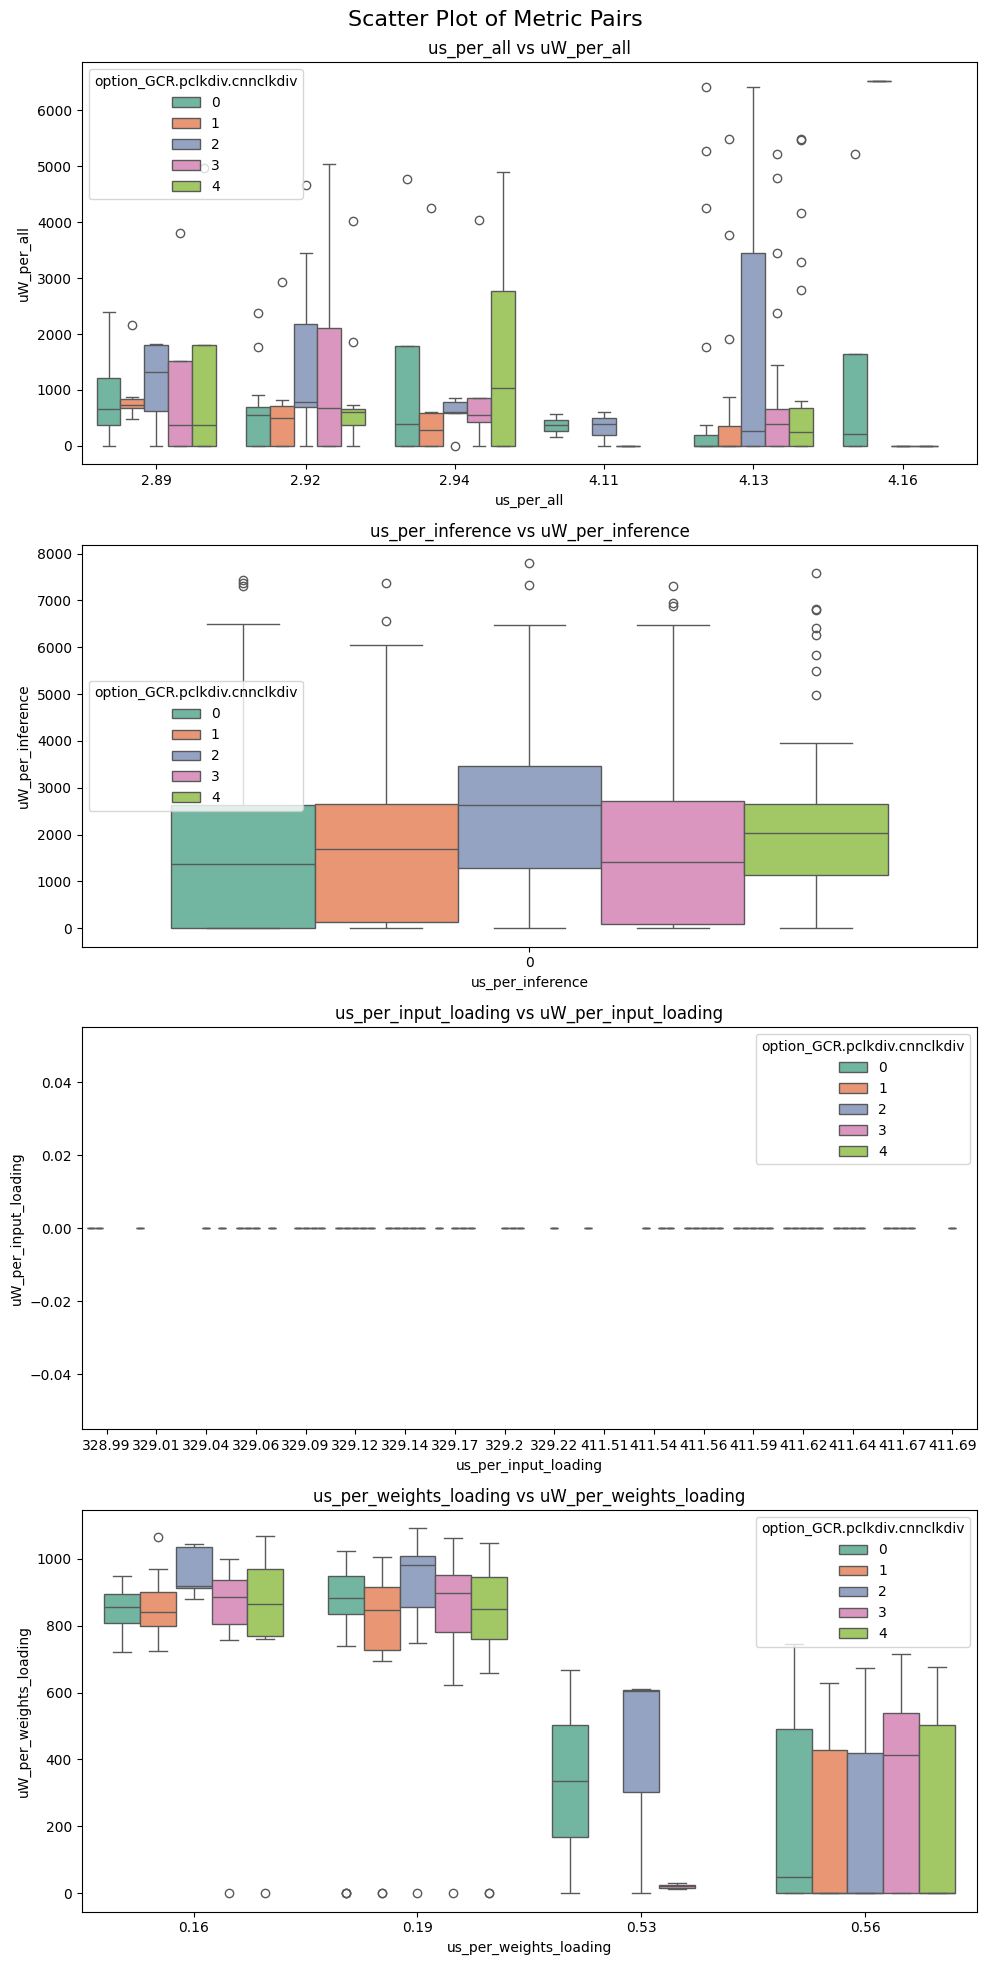

In [ ]:
# Define the list of metric pairs for plotting
metric_pairs = [
    ('us_per_all', 'uW_per_all'),
    ('us_per_inference', 'uW_per_inference'),
    ('us_per_input_loading', 'uW_per_input_loading'),
    ('us_per_weights_loading', 'uW_per_weights_loading'),
]
# Set up subplots based on the number of pairs
fig, axes = plt.subplots(len(metric_pairs), 1, figsize=(10, 5 * len(metric_pairs)))  # Adjust height as needed

# Plot each pair
for i, (x_metric, y_metric) in enumerate(metric_pairs):
    ax1 = axes[i]  # Get the current subplot axis

    # Check if y_metric is a tuple (for dual y-axes)
    if isinstance(y_metric, tuple):
        # Plot the first y metric on the primary y-axis
        y1 = y_metric[0]
        sns.boxplot(
            data=df_filtered, x=x_metric, y=y1, ax=ax1,
            hue=option,
            # label=y1,
            palette='Set2',
            # alpha=0.7,
            # multiple='dodge',
            )

        # Create a second y-axis for the second metric
        ax2 = ax1.twinx()  # Create a twin y-axis
        y2 = y_metric[1]
        sns.boxplot(
            data=df_filtered, x=x_metric, y=y2, ax=ax2,
            hue=option,
            # label=y2,
            palette='Set2',
            # alpha=0.7,
            # multiple='dodge',
            )
    else:
        # Plot the single y metric on the primary y-axis
        sns.boxplot(
            data=df_filtered, x=x_metric, y=y_metric, ax=ax1,
            hue=option,
            # label=y_metric,
            palette='Set2',
            # alpha=0.7,
            # multiple='dodge',
            )

    # Set title for each subplot
    ax1.set_title(f'{x_metric} vs {y_metric if not isinstance(y_metric, tuple) else y_metric[0]}')

# Set title for the overall plot
plt.suptitle('Scatter Plot of Metric Pairs', fontsize=16)

# Create a global legend using handles and labels from the plot
# handles, labels = plt.gca().get_legend_handles_labels()  # Get handles and labels from the current axis
# plt.legend(handles, labels, title='Experiment', loc='upper right')
plt.tight_layout(rect=[0,0,1,0.99])
plt.show()

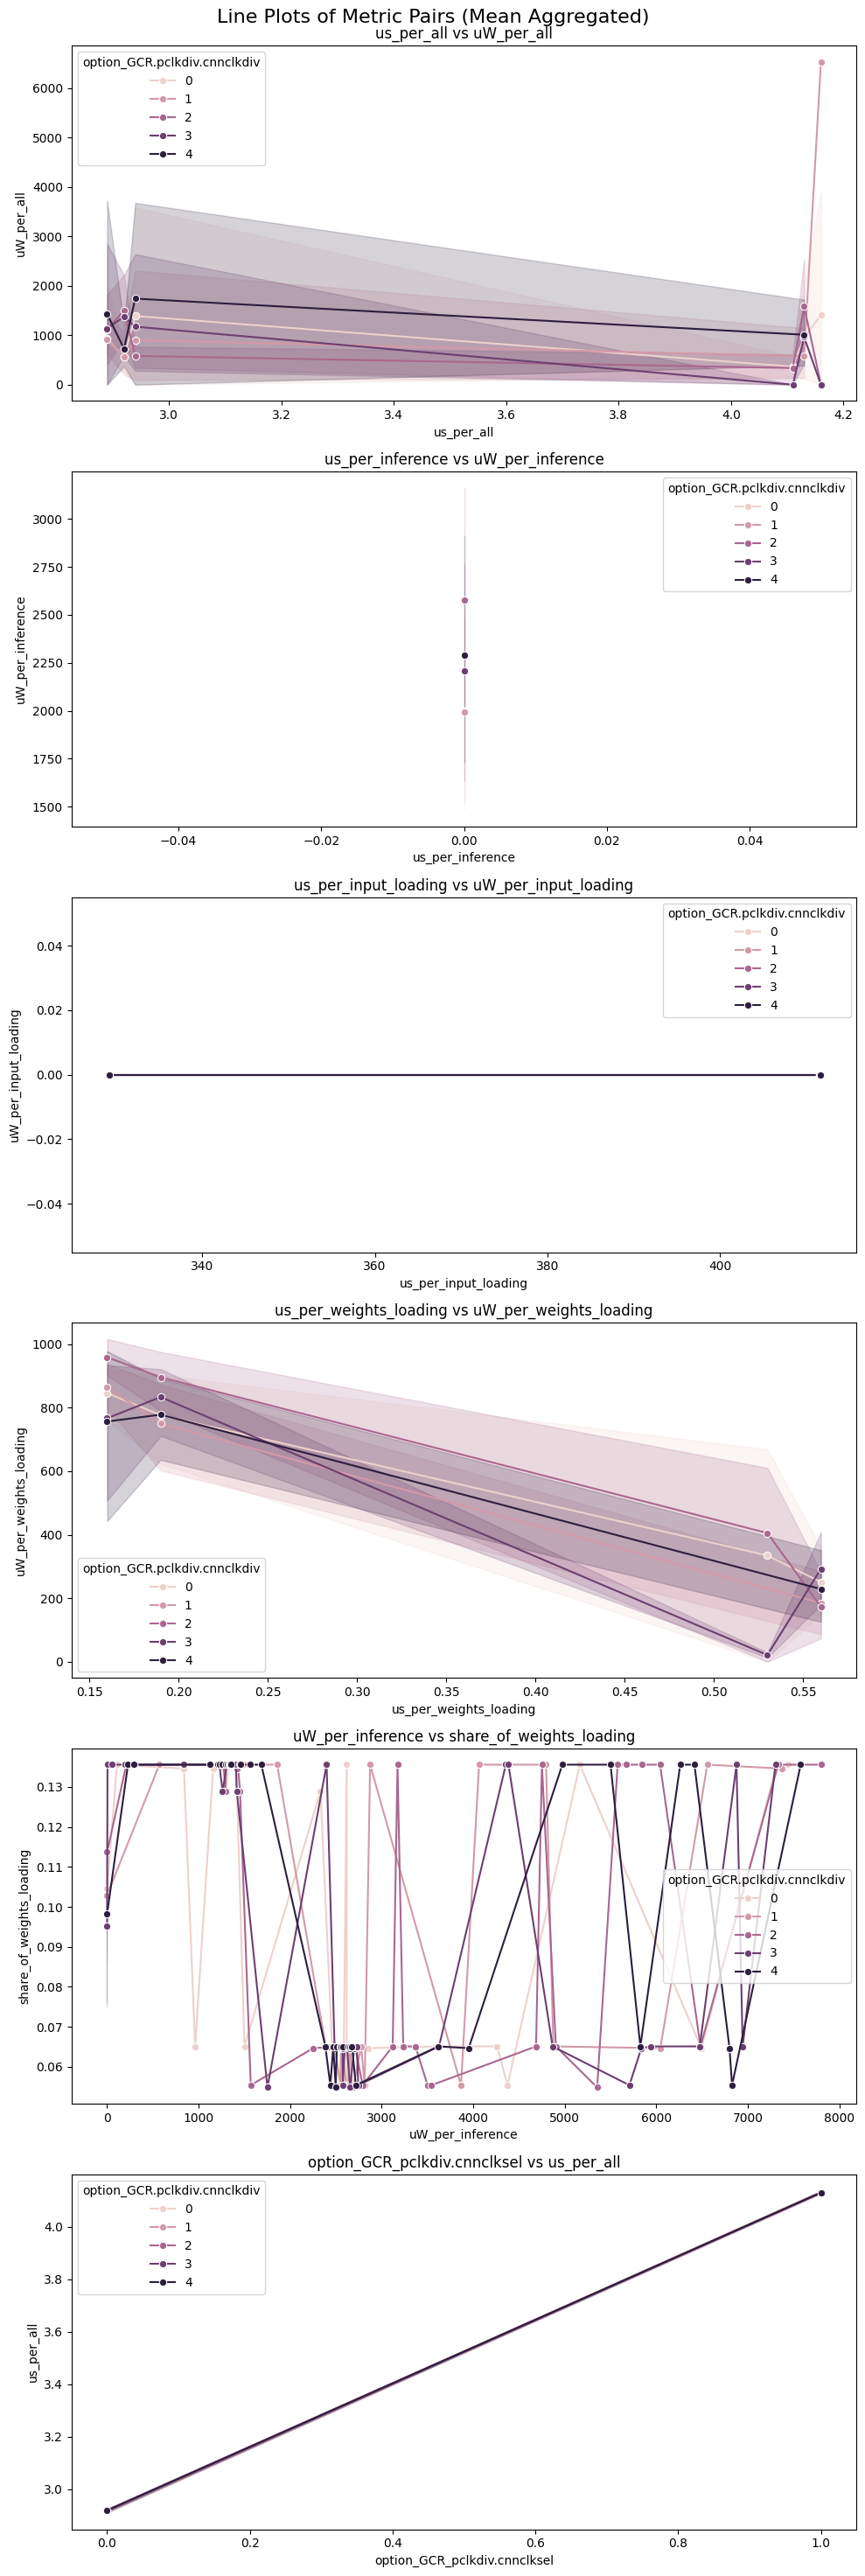

In [ ]:
metric_pairs2 = metric_pairs +[
    ('uW_per_inference', 'share_of_weights_loading'),
    ('option_GCR_pclkdiv.cnnclksel', 'us_per_all'),
]

# Set up the plot
fig, axes = plt.subplots(len(metric_pairs2), 1, figsize=(10, 5 * len(metric_pairs2)))  # Adjust height as needed

# Plot each pair
for i, (x_metric, y_metric) in enumerate(metric_pairs2):
    ax = axes[i]  # Get the current subplot axis
    
    # Group by the x metric and calculate the mean for the y metric(s)
    if isinstance(y_metric, tuple):
        y1 = y_metric[0]
        y2 = y_metric[1]

        # Group and calculate means
        mean_df1 = df_filtered.groupby(x_metric, as_index=False)[y1].mean()
        mean_df2 = df_filtered.groupby(x_metric, as_index=False)[y2].mean()

        # Plot the first metric
        sns.lineplot(data=mean_df1, x=x_metric, y=y1, ax=ax, hue=option, marker='o')
        
        # Plot the second metric on the same axis
        sns.lineplot(data=mean_df2, x=x_metric, y=y2, ax=ax, hue=option, marker='o')
        
    else:
        if y_metric == option:
            # Group and calculate means
            mean_df = df_filtered.groupby([x_metric, option], as_index=False)[y_metric].mean()
            sns.lineplot(data=mean_df, x=x_metric, y=y_metric, ax=ax, marker='o')
        else:
            # Group and calculate means
            mean_df = df_filtered.groupby([x_metric, option], as_index=False)[y_metric].mean()
            sns.lineplot(data=df_filtered, x=x_metric, y=y_metric, ax=ax, hue=option, marker='o')

    # Set title for each subplot
    ax.set_title(f'{x_metric} vs {y_metric if not isinstance(y_metric, tuple) else y_metric[0]}')

# Set the overall title for the figure
fig.suptitle('Line Plots of Metric Pairs (Mean Aggregated)', fontsize=16)

# # Create a global legend using handles and labels from the first subplot
# handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot
# fig.legend(handles, labels, title='Metrics', loc='upper right')

plt.tight_layout(rect=[0,0,1,0.99])
plt.show()